# Decision trees with *sklearn*

Idea of this notebook to make an intuition of how works a decision tree. We will consider decision tree as a classifier.

## Theory

A lot of sources can be found about decision trees. Here we follow [sklearn description](http://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) and apply it on several examples.


> Given training vectors $x_i \in R^n, i=1,..., l$ and a label vector $y \in R^l$, a decision tree recursively partitions the space such that the samples with the same labels are grouped together.

> Let the data at node $m$ be represented by $Q$. For each candidate split $\theta = (j, t_m)$ consisting of a feature $j$ and threshold $t_m$, partition the data into $Q_{left}(\theta)$ and $Q_{right}(\theta)$ subsets

> $$Q_{left}(\theta) = {(x, y) | x_j <= t_m}$$
> $$Q_{right}(\theta) = Q \setminus Q_{left}(\theta)$$

> The impurity at $m$ is computed using an impurity function $H()$, the choice of which depends on the task being solved (classification or regression)

> $$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

> Select the parameters that minimises the impurity

> $$\theta^* = \operatorname{argmin}_\theta G(Q, \theta)$$

> Recurse for subsets $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$ until the maximum allowable depth is reached, $N_m < \min_{samples}$ or $N_m = 1$.

> ** Classification criteria **

> If a target is a classification outcome taking on values $0,1,...,K-1$, for node $m$, representing a region $R_m$ with $N_m$ observations, let

> $$p_{mk} = 1/ N_m \sum_{x_i \in R_m} I(y_i = k)$$

> be the proportion of class $k$ observations in node $m$

> Common measures of impurity are Gini

> $$H(X_m) = \sum_k p_{mk} (1 - p_{mk})$$

> Cross-Entropy

> $$H(X_m) = - \sum_k p_{mk} \log(p_{mk})$$

> and Misclassification

> $$H(X_m) = 1 - \max(p_{mk})$$



In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Synthetic examples

#### A) Single feature example
Let's take the simplest classification example with 1D training vectors $n=1$, for example, $x_i = \sin(0.123 \times i)$ and $y_i = sign(x_i), i=0,...,99$

In [191]:
t = np.arange(100)
x = np.sin(t*0.123 + 0.0012)
y = np.sign(x); y[y < 0] = 0

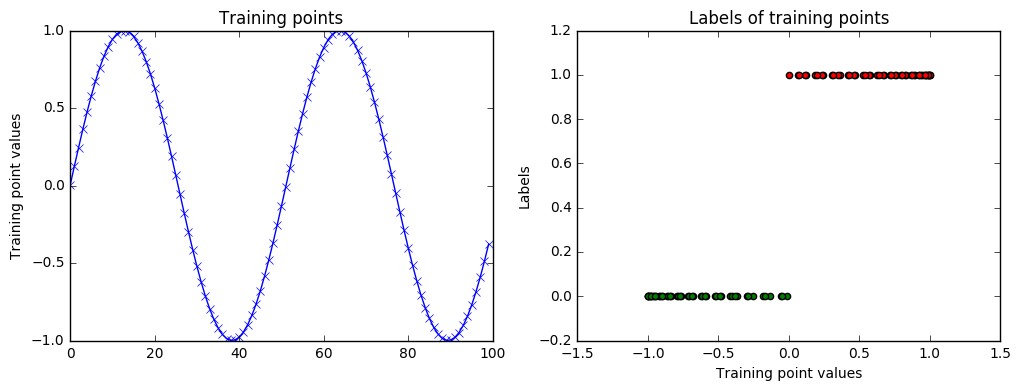

In [150]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Training points")
plt.plot(t, x, 'x-')
plt.ylabel("Training point values")
plt.subplot(122)
plt.title("Labels of training points")
plt.scatter(x[y > 0.5], y[y > 0.5], c='r')
plt.scatter(x[y < 0.5], y[y < 0.5], c='g')
plt.xlabel("Training point values")
plt.ylabel("Labels")

As it is written in the theory, let us search for the split $\theta=(j,t)$ (in our case $j=0$) such that it minimizes the impurity function. 
At first, we initialize the parameter $t$, for example, $t=-0.25$, then we define the first region `R_0` :

``` python
R_0 = x <= t
```

In [151]:
t = -0.25
R_0 = x <= t

Let us define helper functions to compute $p_{mk}$. In our case, $k$ has two values : `0, 1`

In [189]:
def p_mk(y, k, Rm):
    """
    Method to compute the proportion of class k observations in node m
    """
    Nm = np.sum(Rm)
    return 1.0/Nm * np.sum(y[Rm] == k)

In [153]:
p_mk(y, 0, R_0), p_mk(y, 0, ~R_0)

(1.0, 0.10526315789473684)

In [154]:
p_mk(y, 1, R_0), p_mk(y, 1, ~R_0)

(0.0, 0.894736842105263)

Then we can compute, for example, Gini impurity measure 

In [155]:
def Gini_measure(y, region):
    out = 0
    classes = np.unique(y)
    for k in classes:
        out += p_mk(y, k, region)*(1.0 - p_mk(y, k, region))
    return out

In [156]:
Gini_measure(y, R_0), Gini_measure(y, ~R_0)

(0.0, 0.18836565096952917)

Finally, we can compute total impurity function $G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$ :

In [194]:
def impurity_function(Q, theta, H):
    region = Q[0] <= theta
    Nm = len(Q[1])
    n_left = np.sum(region)
    n_right = Nm - n_left
    return n_left * 1.0 / Nm * H(Q[1], region) + n_right * 1.0 / Nm * H(Q[1], ~region) 

In [195]:
impurity_function((x, y), -0.25, Gini_measure)

0.10736842105263163

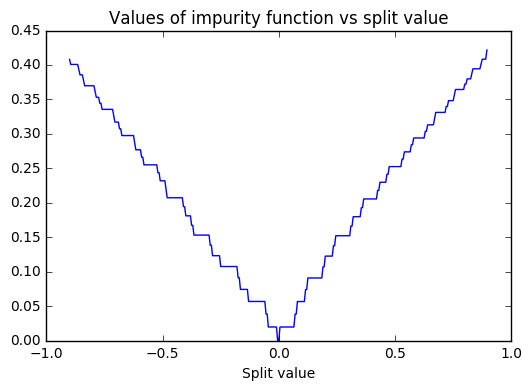

In [197]:
tvals = np.arange(-0.9, 0.9, 0.005)
imp_f_vals = np.zeros(tvals.shape)
for i, t in enumerate(tvals):
    imp_f_vals[i] = impurity_function((x, y), t, Gini_measure)
plt.plot(tvals, imp_f_vals)
plt.title("Values of impurity function vs split value")
plt.xlabel("Split value")

Thus, we see that the minimum of the impurity function is at $t=0.0$ and if we split the dataset at this point we obtain the best split. We can continue to split each subsets, but one of new obtained subsets will be empty.

#### B) Two features example

Next, let us consider another example with 2 features ($n=2$) and two classes: a point ($x_1$, $x_2$) belong to

* the class 0 if $x_1 > 1.25$ and $x_2 > 2.5$
* the class 1 otherwise

In [204]:
x = 10.0 * np.random.rand(100, 2) - [2.0, 2.0]
y = np.zeros(x.shape, dtype=np.int)
condition = (x[:, 0] > 1.25) & (x[:, 1] > 2.5)
y[condition] = 1

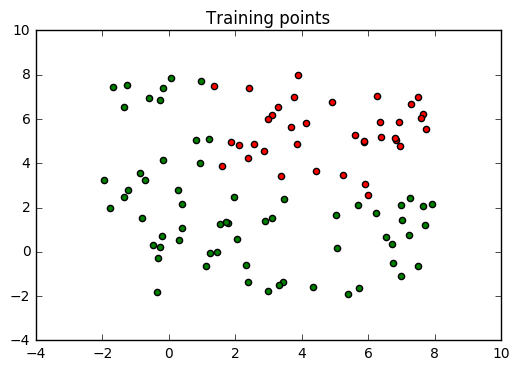

In [205]:
plt.title("Training points")
plt.scatter(x[condition][:, 0], x[condition][:, 1], c='r')
plt.scatter(x[~condition][:, 0], x[~condition][:, 1], c='g')

The procedure is similar to the previous case, we begin with the root node level ($m=0$) and we need to find a split $\theta=(j,t_0)$ such that it minimizes the impurity function. Thus, for each feature $j$ we can find optimal value of $t_0$ and, finally, compare the values of impurity functions. 

In [206]:
Q = (x, y)

We need to update `impurity_function` to take into account feature index $j$ :

In [207]:
def impurity_function2(Q, theta, H):
    region = Q[0][:,theta[0]] <= theta[1]
    Nm = len(Q[1])
    if Nm < 2:
        raise "End of recursion"
    n_left = np.sum(region)
    n_right = Nm - n_left
    return n_left * 1.0 / Nm * H(Q[1], region) + n_right * 1.0 / Nm * H(Q[1], ~region) 

In our case, available value of $x_1$ and $x_2$ are almost the same, therefore we can search the value $t$ of the split in the same range:

Index j=0, a minimum found at t=1.23, value=-0.604571428571
Index j=1, a minimum found at t=3.27, value=-1.08782051282
('Theta^* is : {}', [1, 3.270000000000004])


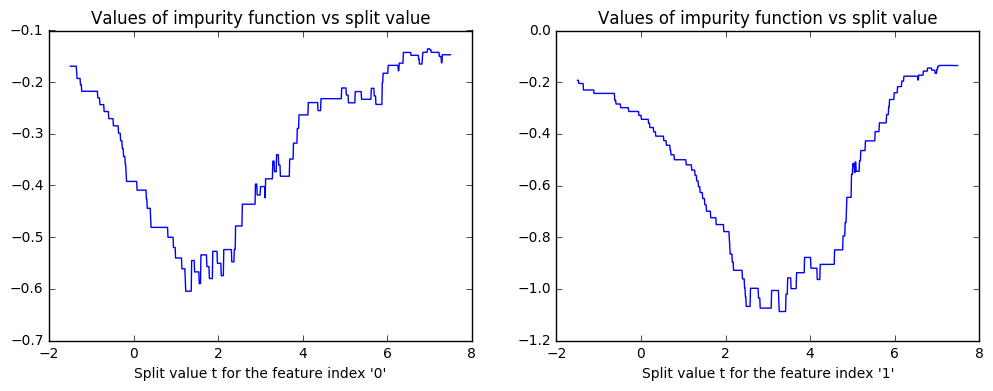

In [212]:
plt.figure(figsize=(12,4))

# Structure to store indices to obtain theta^*
indices_star = [0, 0]

tvals = np.arange(-1.5, 7.5, 0.01)
for j in [0, 1]:
    imp_f_vals = np.zeros(tvals.shape)    
    for i, t in enumerate(tvals):
        imp_f_vals[i] = impurity_function2(Q, (j, t), Gini_measure)
    index_min = np.argmin(imp_f_vals)
    tmin = tvals[index_min]
    
    if imp_f_vals[indices_star[1]] > imp_f_vals[index_min]:
        indices_star[1] = index_min
        indices_star[0] = j
    
    print("Index j={}, a minimum found at t={}, value={}".format(j, tmin, imp_f_vals[index_min]))
    plt.subplot(1,2,j+1)
    plt.plot(tvals, imp_f_vals)
    plt.title("Values of impurity function vs split value")
    plt.xlabel("Split value t for the feature index '%s'" % j)
    
theta_star = [indices_star[0], tvals[indices_star[1]]]
print("Theta^* is : {}", theta_star)

From these plots we can conclude that there is a split $\theta^*$ corresponds to the minimum impurity function among other feature indices, so we choose this split as the first split. So, the initial data $Q$ at the root node ($m=0$) is divided into two parts $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$. 
Next, we process similarly these parts.

In [ ]:
Q[0]

Now we can minimize the impurity function 

In [144]:
# from scipy import optimize
# func = lambda t: impurity_function(t, y, Gini_measure)
# ret = optimize.fmin(func, -0.5, full_output=True, xtol=0.001, ftol=0.001)
# "Found minimum score : {} at {}".format(ret[1], ret[0])

In [3]:

from sklearn.datasets import load_iris
# Load data
iris = load_iris()

In [17]:
iris['data'].shape, iris['target'].shape

((150, 4), (150,))

Thus iris dataset contains 150 training vectors $n=4$ and 150 labels ($l=150$).

Let's consider the node $m=0$ (root node). 

Automatically created module for IPython interactive environment


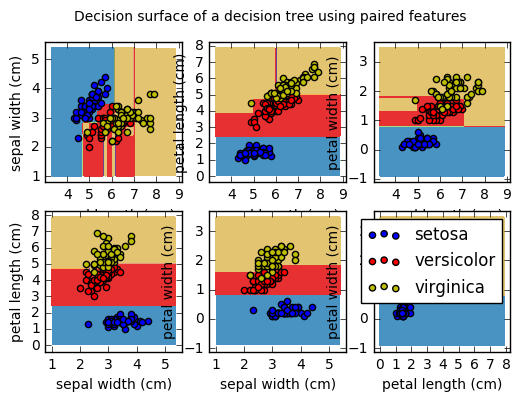

In [1]:
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()